<center> <b> <font size="3"> <font color="green">rfborg </font> :
    your detector technology will be assimilated— resistance is futile! </font> </b> </center> 

In [ ]:
# copy of JPL-test-1-functional-June11.ipynb

In [1]:
import os
from pynq import Overlay
from pynq import Xlnk
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import signal
# import valon_synth9 as Valon

In [30]:
# FIRMWARE UPLOAD
firmware = Overlay("silver-blast_module_eth_v2p2_signed_ddc_sync.bit",ignore_version=True)

# INITIALIZING LMK04208 CLOCK
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [31]:
########################3
# Configure udp ip and mac
##########################
dst_mac_reg = firmware.IP_MAC_gpio_hier.dst_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
src_mac_reg = firmware.IP_MAC_gpio_hier.src_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
ip_reg = firmware.IP_MAC_gpio_hier.ip # offset 0x00 src ip, offset 0x08 dst ip
eth_delay_reg = firmware.eth_delay # programmable delay for eth byte shift
data_in_mux = firmware.data_in_mux
# setting ips
src_ip_int32 = int("c0a80329",16)
dst_ip_int32 = int("c0a80328",16)
src_mac0_int32 = int("deadbeef",16)
src_mac1_int16 = int("feed",16)
dst_mac0_int32 = int("5d092bb0",16) #  startech dongle 80:3f:5d:09:6b:1d
dst_mac1_int16 = int("803f",16) 

# write values
ip_reg.write( 0x00, src_ip_int32) 
ip_reg.write( 0x08, dst_ip_int32)
dst_mac_reg.write( 0x00, dst_mac0_int32)
dst_mac_reg.write( 0x08, dst_mac1_int16)
src_mac_reg.write( 0x00, src_mac0_int32)
src_mac_reg.write( 0x08, src_mac1_int16)

In [4]:
###############################
# Ethernet Delay Lines  
###############################
eth_delay_reg.write(0x00, 20 + (4<<16))#44 + (4<<16)) # data output from eth buffer delay/ input to eth buffer delay <<16 delay
eth_delay_reg.write(0x08, 3) # start pulse out delay
###############################
# Data MUX
###############################
data_in_mux.write( 0x00, 1) # coffee when 0, data when 1
data_in_mux.write( 0x08, (509) + ((8189)<<16) ) # ethernet max write count and max read count
###############################
# DDC shift
###############################
dds_shift=firmware.gpio3.axi_gpio_0 # offset 0x00
#dds_shift.write(0x00dds_shift.write(0x00,12) # 100 : for each addr in ddc bin list, 25 for bin list offs 50

# Generating DDS/DAC Waveform

In [28]:
def phase_shift(ts, phase):
    y = ts*np.exp(1j*phase)
    return ts.real + 1j*y.imag

def norm_wave(ts, max_amp=2**15-1):
    """
     Re-configure generated data values to fit LUT
    """
    Imax = max(abs(ts.real))
    Qmax = max(abs(ts.imag))
    norm = max(abs(ts))
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def surfsUpDude(freq_list, vna = False, verbose=False):
    """
    surfsUpDude Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram. Then we'll have totally ripped waves bruh, schralping the gnar.
    
    params
        freq_list: np.array
            list of tones to generate [Hz]
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=18   # address bit width
    channels= 2    # data points per memory address for DAC
    fs = 1024e6    # sampling rate of D/A, FPGA fabric = fs/2
    C=2            # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
      N = 1000 # number of tones to make
      #freqs = -1*C*np.linspace(-250.0e6, 250.0e6,N) # equally spaced tones
      freqs_up = 1*C*np.linspace(-251e6,-1e6, N/2)
      freqs_lw = 1*C*np.linspace(2.25e6,252.25e6,N/2)
      freqs = np.append(freqs_up,freqs_lw)
    else:
      freqs = C*freq_list # equally spaced tones
    phases = np.random.uniform(-np.pi,np.pi,len(freqs))
    phases[0] = np.pi/2.


    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/data_p # Hz
    fftbin_bw = 500e3 # Hz for effective bandwidth of 512MHz/1024 point fft on adc
    print(freq_res)
    
    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res
    print("{} Frequencies Generated:".format(len(freqs)))
    print(freqs/C*1e-6)
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    fft_bin_nums=np.zeros(len(freqs),dtype=int) # array of all dac bin index
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        fft_bin_nums[i]=(np.round((freqs[i]/fftbin_bw/C)).astype('int'))*C
        print(fft_bin_nums[i])
        delta[bin_num] = np.exp(1j*phases[i]) 
    ts = np.fft.ifft(delta)

    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    # f_beat = (freqs/C)%(fftbin_bw)
    f_fft_bin = fft_bin_nums*fftbin_bw
    f_beat = (freqs/C - f_fft_bin/C)
    
    if verbose:
        print("\nBeat Frequencies:")
        print(f_beat)
        print(freqs/C)

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs),2**9), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs),2**9), dtype="complex")
    bin_num_ddc = np.round(f_beat*2/freq_res) # factor of 2 for half a bin width
    # bin_num_ddc = np.round(f_beat/freq_res) # removed f_beat*2
    
    print("bin num ddc "+str(bin_num_ddc))

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = np.exp(-1j*phases[i])
        beat_ddc[i] = np.conj(np.fft.ifft(delta_ddc[i]))
        
    for i in range(1024):
        if (i<len(freqs)):
            wave_ddc[i::1024] = beat_ddc[i]
        else:
            #wave_ddc[i::1024] = (1+1j)/np.sqrt(2)/2**10
            wave_ddc[i::1024] = 0.
            #wave_ddc[i::1024] = beat_ddc[0] #(1+1j)/np.sqrt(2)/2**10 #sets ones for arrays

#     plt.figure()
#     plt.plot(beat_ddc[0,0:100].real)
#     plt.plot(beat_ddc[0,0:100].imag)
#     plt.show()
    
    dacI, dacQ = norm_wave(ts)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=2**13-1)
    ##############################
    # DDC Values
    ##############################
    ddcQ_val = ((np.int32(ddcQ[1::2]) << 16) + ddcQ[0::2]).astype("int32")
    ddcI_val = ((np.int32(ddcI[1::2]) << 16) + ddcI[0::2]).astype("int32")

    dacQ_val = ((np.int32(dacQ[1::2]) << 16) + dacQ[0::2]).astype("int32")
    dacI_val = ((np.int32(dacI[1::2]) << 16) + dacI[0::2]).astype("int32")

    LUT_I, LUT_Q = np.zeros(data_p).astype("int32"), np.zeros(data_p).astype("int32")
    DDS_I, DDS_Q = np.zeros(data_p).astype("int32"), np.zeros(data_p).astype("int32")

    LUT_I = dacI_val
    LUT_Q = dacQ_val
    DDS_I = ddcI_val
    DDS_Q = ddcQ_val
    return LUT_I, LUT_Q, DDS_I, DDS_Q, freqs, ddcI, ddcQ

#BRAM driver code for bram v0.42
# (to be loaded into python file)
def load_dds(bramN,Z): # new stacked python functionality with new config
    wea    = 2**29
    memlen = 2**18
    load   = 2**29
    sclr   = 2**31
    nchnl  = 1
    
    bramN.write(4,wea)
    k=int(0)
    for i in range(0,memlen):
        bramN.write(0, k<<(32-18)) 
        bramN.write(4,wea)
        for j in range(nchnl): 
            bramN.write(4,j<<19) 
            bramN.write(12,int(Z[nchnl*i+j])) 
        
        bramN.write(4,wea | 1<<28 )
        k+=1
    bramN.write(4,0)
    bramN.write(0,0)
    return

def load_dac(bramN,Z): # new stacked python functionality with new config
    wea    = 2**29
    memlen = 2**18
    load   = 2**29
    sclr   = 2**31
    nchnl  = 1

    bramN.write(4,wea)
    k=int(0)
    for i in range(0,memlen):
        bramN.write(0, k<<(32-18)) 
        bramN.write(4,wea)
        for j in range(nchnl): 
            bramN.write(4,j<<19) 
            bramN.write(12,int(Z[nchnl*i+j])) 
        
        bramN.write(4,wea | 1<<28 )
        k+=1
    bramN.write(4,0)
    bramN.write(0,0)
    return


def load_bin_list(freqs):
    #bin_list=-1*(np.round(freqs* 512/512e6))
    bin_list = np.int64( np.round(freqs/1e6) )
    print("bin_list:"+str(bin_list))
    fft_shift_and_load_bins = firmware.gpio1.axi_gpio_0 # 0x00 fft shift, 0x08 load bins
    accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0-23 accum len, 24 accum rst, 25 sync in

    # initialization 
    sync_in = 2**26
    fft_shift=0
    if len(freqs)>400:
        fft_shift = 1*((2**5)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
    else:
        fft_shift = 1*((2**9)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
    accum_rst = 2**24  # (active low)
    accum_length = (2**18)-1
    
    fft_shift_and_load_bins.write(0x00, fft_shift)
    accum_and_bin_idx.write(0x08, accum_length)
    ################################################
    # Load DDC bins
    ################################################
    #offs=60
    offs=100
    
    
    for addr in range(1024):
         if ((offs-1)<addr<((offs)+len(bin_list))):
             print("addr = {}, bin# = {}".format(addr, bin_list[addr-offs]))
             accum_and_bin_idx.write(0x00, abs(int(bin_list[addr-offs]))) #110 # write bin for address single address
             fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
             fft_shift_and_load_bins.write(0x08,0) # disable we
         else:
             accum_and_bin_idx.write(0x00,0)#0) #110 # write bin for address single address
             fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
             fft_shift_and_load_bins.write(0x08,0) # disable wea
    
    ##################################################33
    # sync low
    #accum_and_bin_idx.write( 0x08, accum_length) # sync low
    return

def load_waveform_into_mem(LI, LQ, DI, DQ):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    DAC_bram_I = firmware.DAC_I.BRAM_I_LUT
    DAC_bram_Q = firmware.DAC_Q.BRAM_Q_LUT
    DDS_bram_I = firmware.DDC_I.BRAM_I_LUT
    DDS_bram_Q = firmware.DDC_Q.BRAM_Q_LUT

    load_dac(DAC_bram_I,LI)
    load_dac(DAC_bram_Q,LQ)
    load_dds(DDS_bram_I, DI)
    load_dds(DDS_bram_Q,DQ)
    ########################
    # Arming DDC Waveform
    ########################
    # initialization 
    sync_in = 2**26
    accum_rst = 2**24  # (active low)
    accum_length = (2**18)-1
    accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0-23 accum len, 24 accum rst, 25 sync in
    # sync high 
    accum_and_bin_idx.write(0x08,accum_length+sync_in) 
    # accum reset low then high
    accum_and_bin_idx.write(0x08,accum_length+accum_rst+sync_in)
    dds_shift.write(0x08,1) # holdings from counting, gpio3
    DDS_bram_Q.write(4,(0<<31)) # BRAM ip
    DDS_bram_I.write(4,(0<<31))
    DDS_bram_Q.write(4,(1<<31))
    DDS_bram_I.write(4,(1<<31)) 
    DDS_bram_I.write(4,(0<<31))
    DDS_bram_Q.write(4,(0<<31))
    dds_shift.write(0x08,0) # clearing gpio3 redge DDS latch
    dds_shift.write(0x00,50) ################# DDS SHIFT #######################
    return 0

In [29]:
LUT_I, LUT_Q, DDS_I, DDS_Q, freqs, ddcI, ddcQ = surfsUpDude(np.linspace(1,50.17,47)*1e6, vna=False, verbose=True)
load_bin_list(freqs)
load_waveform_into_mem(LUT_I, LUT_Q, DDS_I, DDS_Q)

1953.125
47 Frequencies Generated:
[ 1.          2.06933594  3.13769531  4.20703125  5.27539062  6.34472656
  7.41308594  8.48242188  9.55175781 10.62011719 11.68945312 12.7578125
 13.82714844 14.89550781 15.96484375 17.03417969 18.10253906 19.171875
 20.24023438 21.30957031 22.37792969 23.44726562 24.515625   25.58496094
 26.65429688 27.72265625 28.79199219 29.86035156 30.9296875  31.99804688
 33.06738281 34.13671875 35.20507812 36.27441406 37.34277344 38.41210938
 39.48046875 40.54980469 41.61914062 42.6875     43.75683594 44.82519531
 45.89453125 46.96289062 48.03222656 49.1015625  50.16992188]
4
8
12
16
22
26
30
34
38
42
46
52
56
60
64
68
72
76
80
86
90
94
98
102
106
110
116
120
124
128
132
136
140
146
150
154
158
162
166
170
176
180
184
188
192
196
200

Beat Frequencies:
[      0.       69335.9375  137695.3125  207031.25   -224609.375
 -155273.4375  -86914.0625  -17578.125    51757.8125  120117.1875
  189453.125  -242187.5    -172851.5625 -104492.1875  -35156.25
   34179.6875  102

0

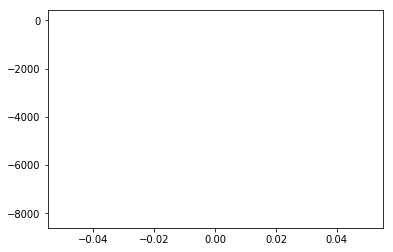

In [43]:
plt.figure()
plt.plot(ddcI[0])
plt.plot(ddcQ[0])
#plt.plot(beat_ddc.imag)
plt.show()

# ADC DATA

In [8]:
bram_ADC_I = firmware.ADC_I.BRAM_SNAP_0 
bram_ADC_Q = firmware.ADC_Q.BRAM_SNAP_0

def get_snap_data(snap):
  snap.write(0x04,0)       #
  snap.write(0x04,2**31)   # toggling sync clear
  snap.write(0x04,2**29)   # 
  d = np.zeros(2**11)    # bram data
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(1):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*1+j]= data
      #print(str(i*8+j))
  snap_data = np.array(d).astype("int32")
  snap_data_0 = ((snap_data >> 16).astype("int16"))#.astype('float') # decoding concatenated values
  snap_data_1 = ((snap_data & (2**(16)-1)).astype("int16"))#.astype('float') 
  d2 = np.zeros(2*2**11)# bram data
  d2[0::2]=snap_data_1
  d2[1::2]=snap_data_0
  return d2

8852.0


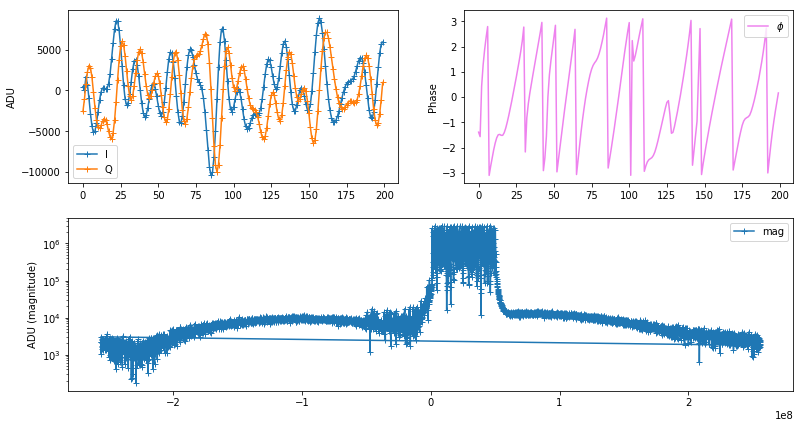

In [23]:
Q3=get_snap_data(bram_ADC_Q) # Q must run first, I is dependent on Q triggering!!!
I3=get_snap_data(bram_ADC_I)

plt.figure(figsize=(13,7))
c = slice(0,200)

plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.subplot(222)
plt.plot(np.arctan2(Q3[c],I3[c]),color="violet",label=r'$\phi$')
plt.ylabel("Phase")
plt.legend()

plt.subplot(2,2,(3,4))
spec=np.fft.fft(I3+1j*Q3)
spec_freqs = np.fft.fftfreq(len(I3),1/512e6)
spec=abs(spec) 
plt.semilogy(spec_freqs,spec,"-+",label="mag")
plt.ylabel("ADU (magnitude)")
plt.legend()
plt.show()

In [ ]:
np.max(spec)

In [ ]:
np.sort((1,4,2))
lmag = np.max(spec[401:])
umag = spec[400]
old_diff = umag-lmag
print(2.*np.arctan(lmag/umag) )
print(2.*np.arctan(umag/lmag) )
print(old_diff)
print(umag-lmag)

In [ ]:
plt.figure()
spec=np.fft.fft(I3[0:1024]+1j*Q3[0:1024])
spec_freqs = np.fft.fftfreq(len(I3[0:1024]),1/512e6)
spec=abs(spec)
plt.semilogy(spec_freqs,spec,"-+",label="mag")
plt.ylabel("ADU")
plt.legend()
plt.show()

## Polyphase Filterbank Snap

In [10]:
pfbIQ=firmware.PFB_SNAP_SYNC.BRAM_SNAPIII_v1_0_0
# make sure to toggle sync (gpio) first
def get_pfb_data(snap):
  snap.write(0x04,0)       #
  snap.write(0x04,2**31)   # toggling sync clear
  snap.write(0x04,2**29)       # 

  d = np.zeros(4*2**11)# bram data 
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(4):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*4+j]= data

  snap_data = np.array(d).astype("uint32")

  snap_data=snap_data<<14
  return snap_data

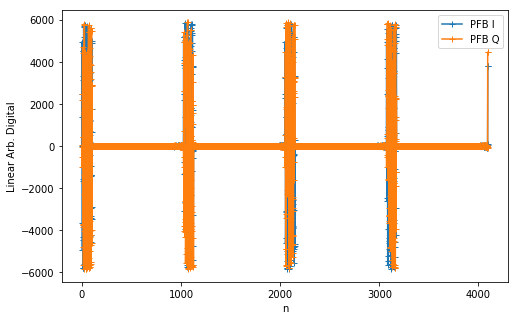

67.446274915669
4293.284174149203


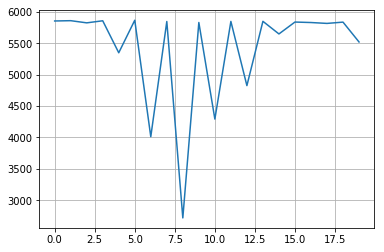

In [24]:
IQpfb_dat = get_pfb_data(pfbIQ).astype("int32")

Ipfb_f = IQpfb_dat[0::2].astype("float")/2**14
Qpfb_f = IQpfb_dat[1::2].astype("float")/2**14

SPECpfb = Ipfb_f + 1j*Qpfb_f
mag = abs(SPECpfb)

plt.figure(figsize=(8,5))
#plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
plt.xlabel("n"); plt.ylabel("Linear Arb. Digital")
#plt.plot(mag)
plt.plot(Ipfb_f,"-+",label='PFB I')
plt.plot(Qpfb_f,"-+",label='PFB Q')

#plt.xlim(0,1024)
#plt.plot(Qpfb_f,"-+",label='Q')
plt.legend()
#plt.savefig("pfb_snap_single_tone.png",dpi=300)
plt.show()
print(mag[0])


plt.figure()
#plt.plot(abs(Ipfb_f[0:1024]))
plt.plot(mag[40:60])
print(mag[50])
plt.grid()
#plt.plot(mag[2048:3072])

In [179]:
mag[500]

3.1622776601683795

# Digital Down Conversion

In [12]:
def get_ddc_data(snap):
  snap.write(0x04,0)       #
  snap.write(0x04,2**31)   # toggling sync clear
  snap.write(0x04,2**29)       # 

  d = np.zeros(4*2**11)# bram data 
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(4):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*4+j]= data

  snap_data = np.array(d).astype("uint32")

  #snap_data=snap_data<<13
  return snap_data<<13

In [13]:
ddc_snap = firmware.DDC_SNAP_SYNC.BRAM_SNAPIII_v1_0_0

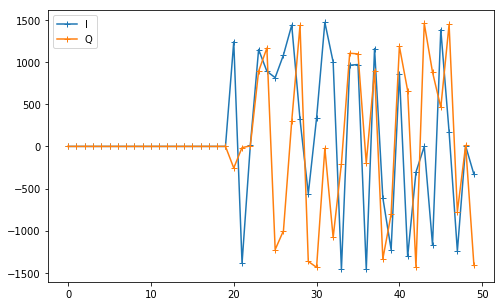

In [27]:

ddc_IQ_dat = get_ddc_data(ddc_snap).astype("int32")

#Iddc_f = ddc_IQ_dat[0::2][0:1024].astype("float")
#Qddc_f = ddc_IQ_dat[1::2][0:1024].astype("float")
Iddc_f = ddc_IQ_dat[0::2].astype("float")/2**13
Qddc_f = ddc_IQ_dat[1::2].astype("float")/2**13

# roll array by 21 to line up with fft bins
#Iddc_f = np.roll(Iddc_f,-21)
#Qddc_f = np.roll(Qddc_f,-21)

plt.figure(figsize=(8,5))
plt.plot(Iddc_f[100:150],"-+",label='I')
plt.plot(Qddc_f[100:150],"-+",label='Q')
#plt.xlim(200,800)
plt.legend()
plt.show()

# plt.figure()
# #plt.plot(abs(Iddc_f[0:1024]+1j*Qddc_f[0:1024]))
# plt.plot(abs(Iddc_f+1j*Qddc_f))
# #plt.xlim(210,230)
# plt.show()

In [58]:
Iddc_f

array([0., 0., 0., ..., 0., 0., 0.])

## Vector Accumulate and Downsample

In [20]:
def get_accum_data(snap,slp=.003):
  snap.write(0x04,0)       #
  snap.write(0x04,(2**29) + (2**31))   # toggling sync clear
  snap.write(0x04,2**29)       # 
  sleep(slp)

  d = np.zeros(4*2**11)# bram data 
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(4):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*4+j]= data
  snap_data = np.array(d)#.astype("int32")
  return snap_data

In [21]:
accum_snap = firmware.ACCUM_SNAP_SYNC.BRAM_SNAPIII_v1_0_0

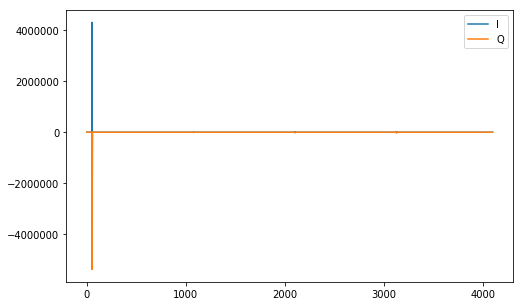

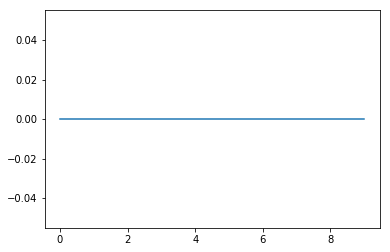

In [188]:
accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
Iacc_f = accum_IQ_dat[0::2]#.astype("float")
Qacc_f = accum_IQ_dat[1::2]#.astype("float")
Ia, Qa = np.array(Iacc_f).astype(float), np.array(Qacc_f).astype(float)

plt.figure(figsize=(8,5))
plt.plot(Ia[:],label='I')
plt.plot(Qa[:],label='Q')
plt.legend()
#plt.xlim(0,1024)
plt.show()

plt.figure()
IQMAG=np.sqrt(Ia**2+Qa**2)
plt.plot(IQMAG[0:10])
#plt.xlim(175,225)
plt.show()

In [ ]:
Is=[]
Qs=[]
xs=[]
for _ in range(150):
    x=get_accum_data(accum_snap).astype("int32")
    I=x[::2]
    Q=x[1::2]
    #print(x[150:155])
    Is.append(I)
    Qs.append(Q)
    xs.append(x)

In [ ]:
plt.plot([I[60] for I in Is],'x'); 
plt.plot([Q[60] for Q in Qs],'x'); 
#plt.show()
plt.plot([I[61] for I in Is],'x'); 
plt.plot([Q[61] for Q in Qs],'x'); 
#plt.show()
plt.plot([I[59] for I in Is],'x'); 
plt.plot([Q[59] for Q in Qs],'x'); 
plt.show()

In [ ]:
accum_IQ_dat[0:10]

In [ ]:
# mag_shift = np.zeros(1024)
l=2
for j in range(10):
    print("run {}".format(j))
    print("="*25)
    shiftmax=0
    for i in range(0, 512):
        dds_shift.write(0x00,i)
        sleep(0.75)
        #if i%50 == 0:
        #  print(i)
        accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
        Iacc_f = accum_IQ_dat[0::2][1024*l:1024*(l+1)].astype("float")
        Qacc_f = accum_IQ_dat[1::2][1024*l:1024*(l+1)].astype("float")
        MAG =  np.max(np.sqrt(Iacc_f**2+Qacc_f**2))
        #print(MAG)
        if MAG > shiftmax:
            shiftmax=MAG
            print("shift: {} maxshift: {}".format(i, shiftmax))

In [ ]:
 dds_shift.write(0x00,270) # 451 ,133  233

In [ ]:
# shift: 0 maxshift: 85817.82468112321
# shift: 77 maxshift: 89913.91105385195
# shift: 101 maxshift: 94725.08662967799
# shift: 175 maxshift: 97788.40938475275
# shift: 207 maxshift: 106220.30252734173
# shift: 246 maxshift: 112771.61490818512
# shift: 521 maxshift: 112940.4150913215
# shift: 563 maxshift: 114827.0322049647
# shift: 655 maxshift: 116114.17238649208

In [ ]:
(400e6)/900

In [ ]:
#114

# 40-60
# 210-260
# 340 - 400

In [ ]:
l=2
shiftmax=0
# kN=1
for i in range(0,512):
        dds_shift.write(0x00,i)
        sleep(1)
        if i%1 == 0:
          print(i)
#         accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
#         Iacc_f = accum_IQ_dat[0::2][1024*l:1024*(l+1)].astype("float")
#         Qacc_f = accum_IQ_dat[1::2][1024*l:1024*(l+1)].astype("float")
#         MAG =  np.max(np.sqrt((Iacc_f**2+Qacc_f**2))
#         #print(MAG)
#         if MAG > shiftmax:
#             shiftmax=MAG
#             print("shift: {} maxshift: {}".format(i, shiftmax))

In [ ]:
dds_shift.write(0x00,12)
# 25 addr offs 50
# 100 for writing all addrs

In [ ]:
10.*np.log10(1e8)